In [ ]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt

from sat_metropolis import smt, mcmc, sat, utils

In [2]:
# Assumption, all bit-vectors are of the same size
## NOTE: It looks like we need to always have one extra bit? For the sign?
num_bits = 4
num_vars = 3
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2]])) # important
g.add(ULE(0,x[0]))
g.add(ULE(x[0],3))
g.add(ULE(0,x[1]))
g.add(ULE(x[1],3))
g.add(ULE(0,x[2]))
g.add(ULE(x[2],6))
g.add(x[0] + x[1]  == x[2])

In [3]:
# sanity check (optional)
solve(g)

[x11 = False,
 x01 = True,
 x20 = False,
 x10 = False,
 x00 = False,
 x21 = True,
 x02 = False,
 x03 = False,
 x13 = False,
 x12 = False,
 x22 = False,
 x1 = 0,
 x0 = 2,
 x2 = 2,
 x23 = False]


In [4]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	44/44/0
independent support size:  	0
clauses (all/long/binary/unit): 138/66/65/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	519 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	519 MB

Sample #1 of 3 is already a complete assignment.  Continuing...
Completing sample #2 of 3 which has 4 variables unset and 1196 samples.
Completing sample #3 of 3 which has 8 variables unset and 1963 samples.
STAGE #2 - COMPLETE


variables (total / active / free)	44/44/0
clauses (removed) 		138 (0)
decisions 				10
conflicts 				0
co

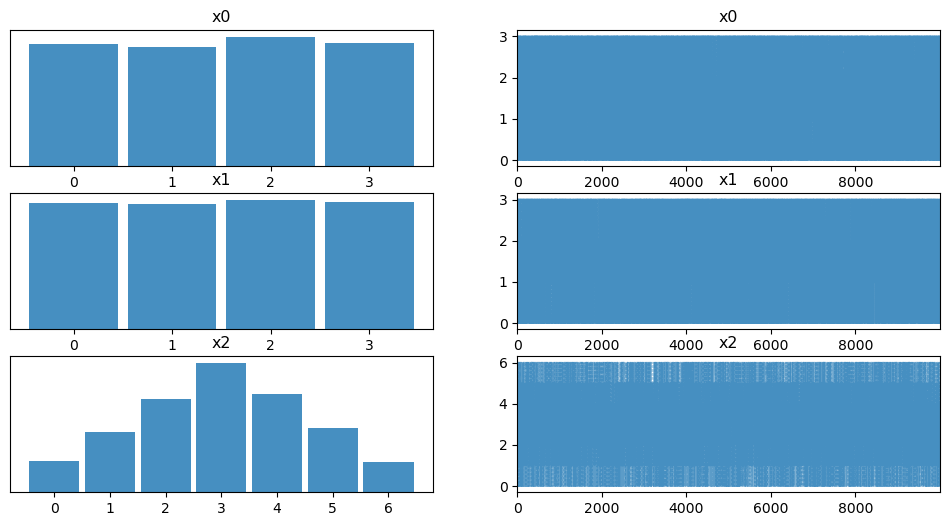

In [5]:
az.plot_trace(trace)
plt.savefig('spur_trace_plot.png',dpi=150);

In [6]:
# Diagnosis
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.516,1.115,0.0,3.0,0.006,0.004,39353.0,39520.0,1.0
x1,1.507,1.117,0.0,3.0,0.006,0.004,39163.0,39474.0,1.0
x2,3.022,1.567,0.0,5.0,0.008,0.006,38914.0,39440.0,1.0


In [7]:
utils.save_trace(trace, f'triangle_SAT_{num_vars}_{num_bits}.nc')

## Non-uniform prior

In [8]:
def prior(s: dict[str, int]):
    x0 = s['x0']
    x1 = s['x1']
    p_x0 = 1/3 if x0 < 2 else 1/6
    p_x1 = 1/4

    return p_x0 * p_x1

def likelihood(s: dict[str, int]):
    return 1

In [9]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4,
                                           f = lambda s: likelihood(s)*prior(s))

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	47/47/0
independent support size:  	0
clauses (all/long/binary/unit): 151/75/69/7
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	409 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	409 MB

Sample #1 of 4 is already a complete assignment.  Continuing...
Completing sample #2 of 4 which has 4 variables unset and 1221 samples.
Completing sample #3 of 4 which has 11 variables unset and 1871 samples.
Completing sample #4 of 4 which has 8 variables unset and 1881 samples.
STAGE #2 - COMPLETE


variables (total / active / free

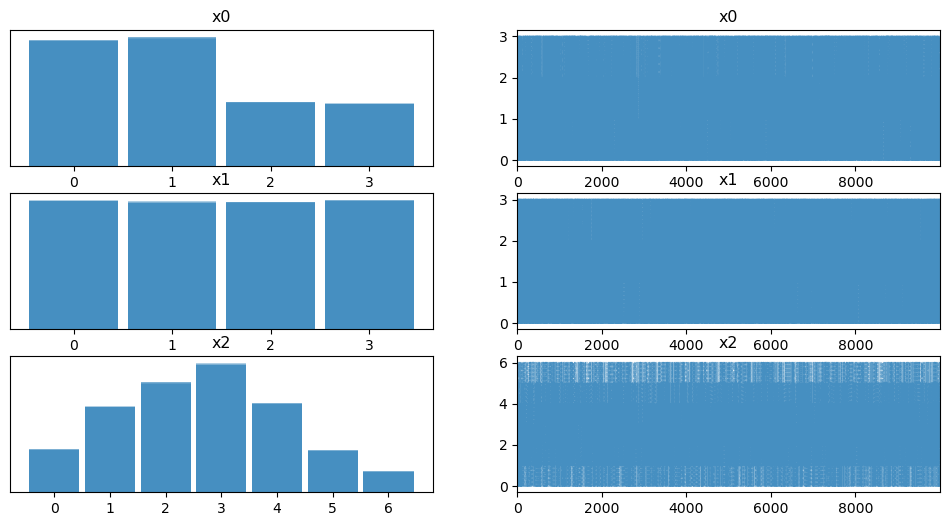

In [10]:
# posterior plot
az.plot_trace(trace);
# plt.savefig('spur_trace_plot_non_uniform.png',dpi=150);

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.165,1.061,0.0,3.0,0.007,0.005,24080.0,23418.0,1.0
x1,1.501,1.121,0.0,3.0,0.007,0.005,28648.0,28518.0,1.0
x2,2.665,1.535,0.0,5.0,0.009,0.007,27194.0,24457.0,1.0


In [12]:
utils.save_trace(trace, f'triangle_prior_SAT_{num_vars}_{num_bits}.nc')